In [1]:
import numpy as np
import matplotlib.pyplot as plt

from hnc_n_multiscale import  HNC_solver

# Two Species

Here we do QSP interactions between electrons and one ion type. 

Using $\tilde{r}\equiv r/r_s$, we implement potentials 
\begin{align}
\beta v_{ee}(\tilde{r}) &=  \frac{\Gamma_{ee}}{\tilde{r}}\left( 1- \exp[-\tilde{r} r_s/\Lambda_e]\right) +  \ln2 \exp\left[-\tilde{r}^2 r_s^2/(\pi \Lambda_e^2 \ln 2)\right]\\
\beta v_{ei}(\tilde{r}) &=  \frac{\Gamma_{ei}}{\tilde{r}}\left( 1- \exp[-\tilde{r} r_s/\Lambda_e]\right)\\
\beta v_{ii}(\tilde{r}) &=  \frac{\Gamma_{ii}}{\tilde{r}}
\end{align}
For  
\begin{align}
\Gamma_{ee}&=\frac{\beta e^2}{r_s}\\
\Gamma_{ei}&=\frac{\beta Z_i e^2}{r_s}\\
\Gamma_{ii}&=\frac{\beta Z_i^2 e^2}{r_s}\\
\end{align}


### "Classical-Map  Hypernetted  Chain  Calculations  for  Dense Plasmas"
###### R. Bredow1∗, Th. Bornath1, W.-D. Kraeft1, M.W.C. Dharma-wardana,and R. Redmer1
[doi.org/10.1002/ctpp.201400080](https://doi.org/10.1002/ctpp.201400080)


### Simple Classical Mapping of the Spin-Polarized Quantum Electron Gas: Distribution Functions and Local-Field Corrections
###### M. W. C. Dharma-wardana and F. Perrot
[DOI:https://doi.org/10.1103/PhysRevLett.84.959](https://doi.org/10.1103/PhysRevLett.84.959)



Define physical constants

In [2]:
# k_B = 1.380649e-23  # Boltzmann constant [J/K]
# hbar=  6.62607015e-34 # Planck [J/s]
eV = 0.0367512 # So 4 eV = 4 * 0.036.. in natural units
Kelvin = 8.61732814974493e-5*eV #Similarly, 1 Kelvin = 3.167e-6... in natural units 
π = np.pi
# [AU]
rs  = 3
T   = 100*eV 
Zstar=3#

β   = 1/T
m_e = 1


Λe  = np.sqrt(  β*2*π /m_e )
Λe_star  = np.sqrt(  β*2*π /m_e )/rs
Γee = β/rs 
Γei = -Zstar*β/rs 
Γii = Zstar**2*β/rs 
print(Γee, Γei, Γii)

0.0906999862136021 -0.2720999586408063 0.8162998759224189


Plug into get potentials


In [3]:
from scipy.special import erf

# Build Components for QSP's

def βv_Deutsch(Γ, r):
    return Γ/r* (  np.exp(-2*π*r/Λe_star)  )

# Kelb looks really weird??
# def βv_Kelb(Γ,r):
#     return Γ/r*(  np.exp(-2*π*r**2/Λe_star**2)- np.sqrt(2)*π*r/Λe_star *erf(np.sqrt(2*π)*r/Λe_star))

def βv_Pauli(r):
    return  np.log(2) * np.exp(-4*π* r**2 /( Λe_star**2))


######### Build Actual QSP's

def βvee(r):
    return βv_Deutsch(Γee,r) + βv_Pauli(r)

def βvei(r):
    return βv_Deutsch(Γei,r)

def βvei_atomic(r):
    r_c = 3/5 #3/5 r_s in linear n_b(r) model
    return np.heaviside(r - r_c,0.5) * βvei(r)

def βvii(r):
    return Γii/r 


First, we initialize the hnc

# Electron Only

In [4]:
# N_species = 1
# Gamma = np.array(  [[Γee]])


# names = ["Electron", ] 
# kappa = 1
# rho = np.array([  Zstar*3/(4*np.pi) ])
# hnc = HNC_solver(N_species, Gamma=Gamma, kappa=kappa, tol=1e-4,
#                  kappa_multiscale=5, rho = rho, num_iterations=int(10e2), 
#                  R_max=10, N_bins=1000, names=names)

# hnc.βu_r_matrix[0,0] = βvee(hnc.r_array)
# hnc.split_βu_matrix()
# hnc.get_βu_k_matrices()
# hnc.plot_βu_all_species()

# hnc.HNC_solve(alpha=1)
# gr_files = ["/home/zach/plasma/atomic_forces/data/RDF/Al_0.5eV_rs3_KS-MD.txt", "/home/zach/plasma/atomic_forces/data/RDF/Al_0.5eV_rs3_TFY-MD.txt"]
# gr_labels= ["KS MD", "TFY MD"]
# hnc.plot_g_all_species(data_to_compare=gr_files, data_names=gr_labels)
# hnc.plot_species((0,0))

# Electron Ion

In [5]:
N_species = 2
Gamma = np.array(  [[Γii,  Γei],
                    [Γei,  Γee]])


names = ["Ion-1", "Electron", ] 
kappa = 1
rho = np.array([  3/(4*np.pi), Zstar * 3/(4*np.pi) ])
hnc2 = HNC_solver(N_species, Gamma=Gamma, kappa=kappa, tol=1e-5,
                 kappa_multiscale=1, rho = rho, num_iterations=int(2), 
                 R_max=10, N_bins=500, names=names)


then we create the potential matrix, βu_matrix 

In [6]:
βu_r_matrix = np.array([[βvii(hnc2.r_array), βvei(hnc2.r_array)],
                        [βvei(hnc2.r_array), βvee(hnc2.r_array)]])
hnc2.set_βu_matrix(βu_r_matrix)

0: Err in c_r: 0.000


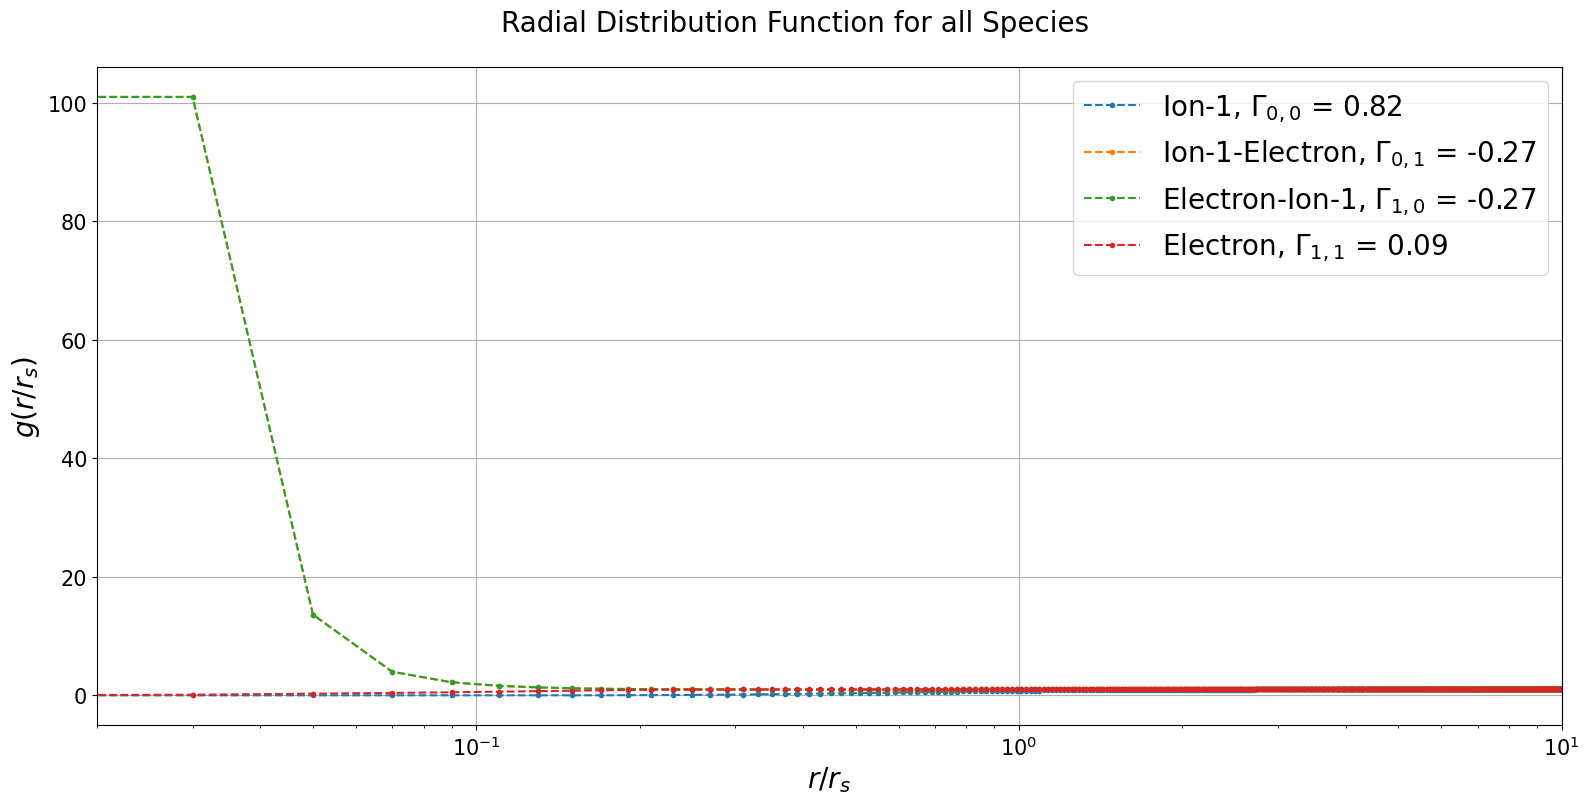

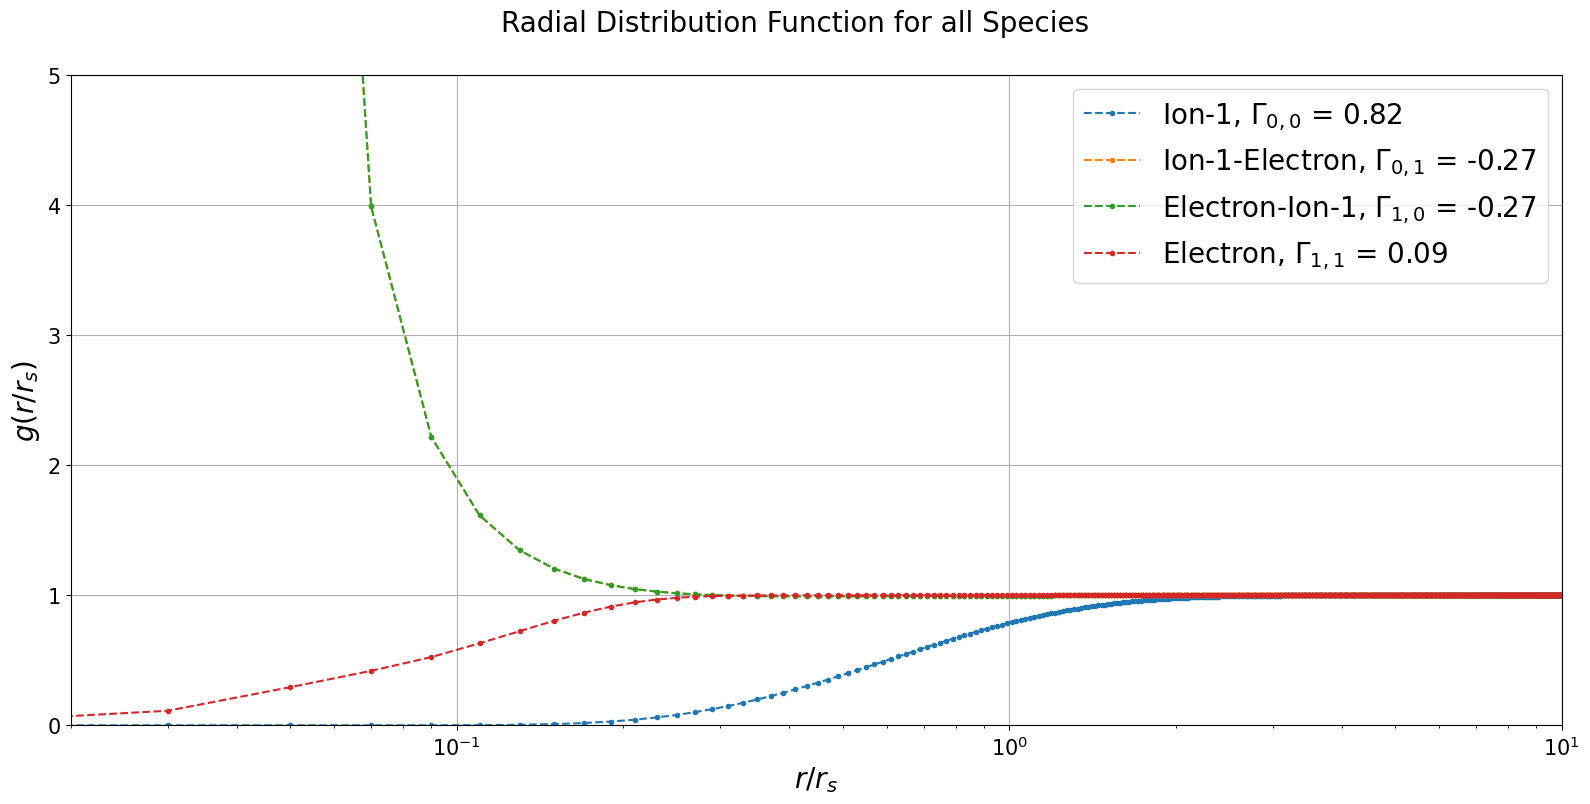

In [14]:
hnc2.HNC_solve(alpha=1)
hnc2.plot_g_all_species()
hnc2.plot_g_all_species(gmax = 5)

# Debug

In [12]:
# hnc2.plot_βu_all_species()

In [13]:
# hnc2.h_r_matrix = -1 + np.exp(- hnc2.βu_r_matrix)
# hnc2.plot_species((1,1))
# hnc2.plot_g_all_species()